In [1]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.4 MB/s eta 0:00:00


In [2]:
! pip install pytorch_metric_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from pytorch_metric_learning.losses import CircleLoss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [4]:
pip install seaborn

From avg pooling

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNet18Features(nn.Module):
    def __init__(self):
        super(ResNet18Features, self).__init__()
        original_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(original_model.fc.in_features, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        features = x
        out = self.fc(features)
        return features, out

model = ResNet18Features().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [6]:
criterion = CircleLoss(m=0.9, gamma=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 40804386.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def apply_fgsm(model, loader):
    adversarialset = []
    normalset = []
    model.eval()
    for data in loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        normalset.append((inputs.cpu(), labels.cpu()))
        inputs.requires_grad = True
        outputs = model(inputs)[1]
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        inputs_grad = inputs.grad.data
        perturbed_inputs = fgsm_attack(inputs, 0.1, inputs_grad)
        adversarialset.append((perturbed_inputs.cpu(), labels.cpu()))
    model.train()
    return normalset, adversarialset

Epoch 1/15, Loss: 0.0054
Epoch 2/15, Loss: 0.0039
Epoch 3/15, Loss: 0.0034
Epoch 4/15, Loss: 0.0031
Epoch 5/15, Loss: 0.0029
Epoch 6/15, Loss: 0.0028
Epoch 7/15, Loss: 0.0024
Epoch 8/15, Loss: 0.0024
Epoch 9/15, Loss: 0.0023
Epoch 10/15, Loss: 0.0020
Epoch 11/15, Loss: 0.0018
Epoch 12/15, Loss: 0.0018
Epoch 13/15, Loss: 0.0016
Epoch 14/15, Loss: 0.0017
Epoch 15/15, Loss: 0.0014


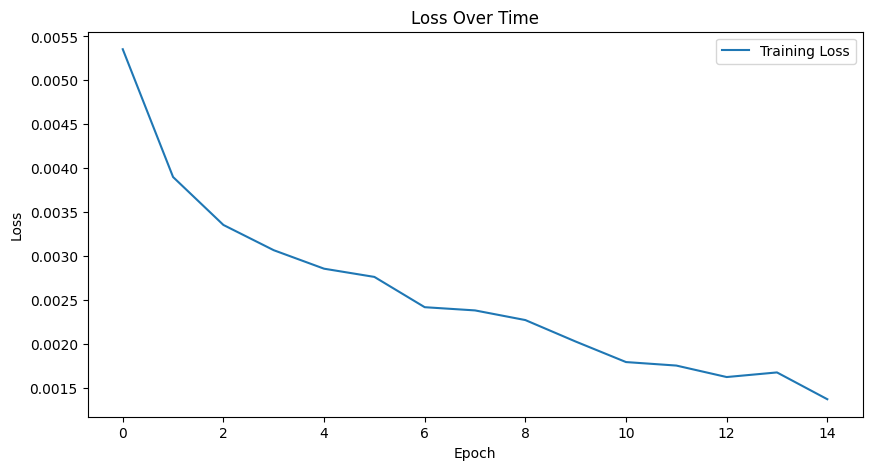

In [8]:
num_epochs = 15
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        features, _ = model(inputs)
        loss = criterion(features, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [9]:
normalset, adversarialset = apply_fgsm(model, testloader)

def extract_features_and_labels(data_list):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in data_list:
            images = images.to(device)
            features, _ = model(images)
            features_list.append(features.cpu().detach().numpy())
            labels_list.append(labels.cpu().detach().numpy())
    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

train_features, train_labels = extract_features_and_labels(trainloader)

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(train_features, train_labels)

original_test_features, original_test_labels = extract_features_and_labels(normalset)
original_predictions = knn.predict(original_test_features)
original_accuracy = accuracy_score(original_test_labels, original_predictions)
print(f'Original Test Data Accuracy using kNN: {original_accuracy * 100:.2f}%')

adv_test_features, adv_test_labels = extract_features_and_labels(adversarialset)
adv_predictions = knn.predict(adv_test_features)
adv_accuracy = accuracy_score(adv_test_labels, adv_predictions)
print(f'Adversarial Test Data Accuracy using kNN: {adv_accuracy * 100:.2f}%')


Original Test Data Accuracy using kNN: 77.03%
Adversarial Test Data Accuracy using kNN: 33.97%


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


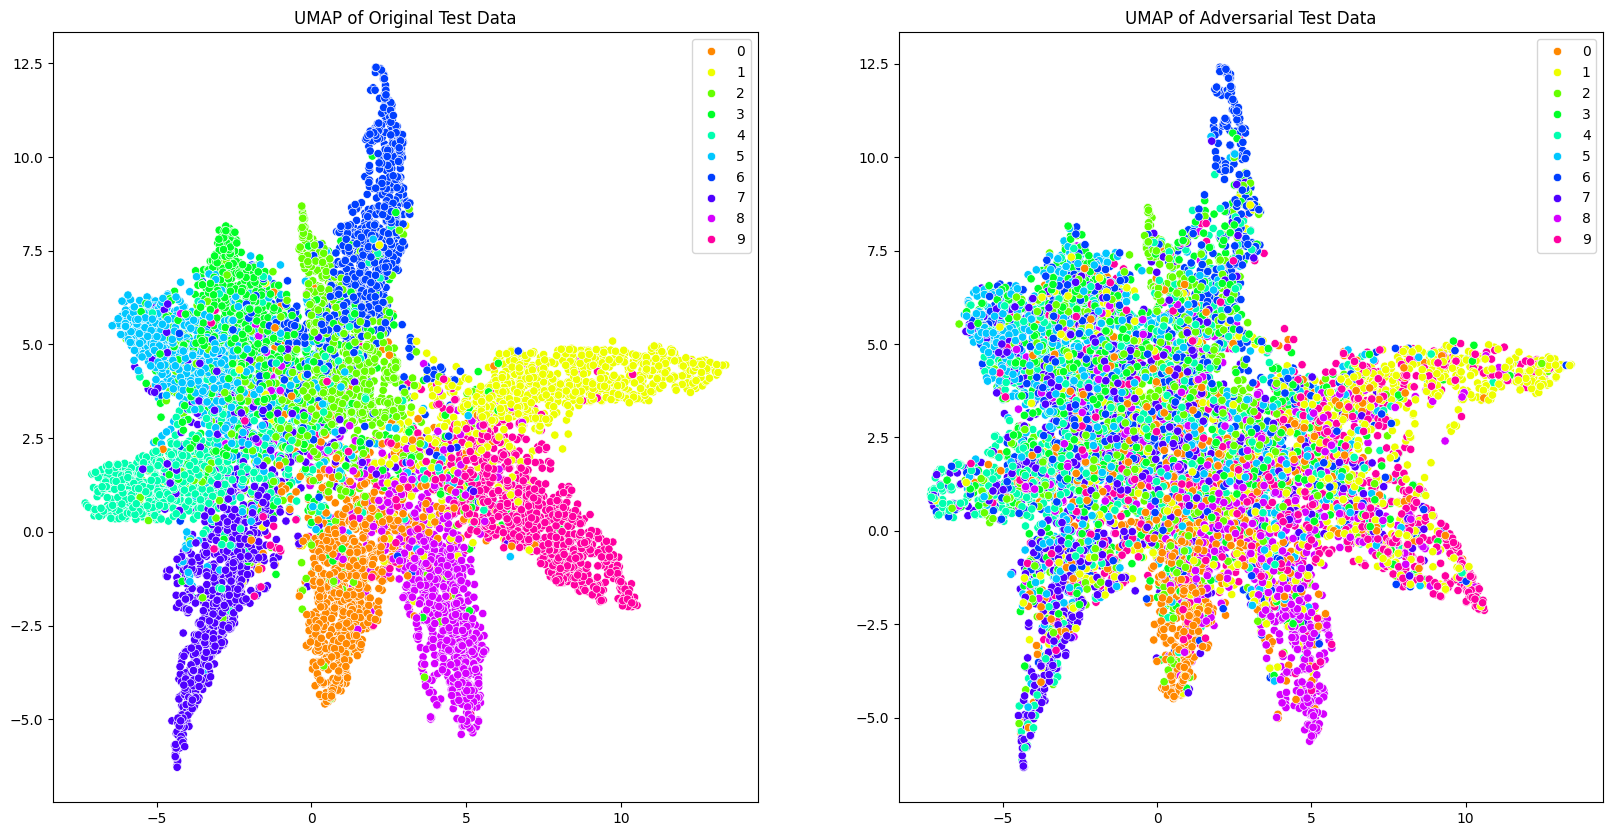

In [10]:
import seaborn as sns

umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)

combined_features = np.concatenate((original_test_features, adv_test_features), axis=0)
umap_embedding = umap_reducer.fit_transform(combined_features)

split_index = original_test_features.shape[0]
umap_original = umap_embedding[:split_index]
umap_adv = umap_embedding[split_index:]

plt.figure(figsize=(20, 10))
palette = sns.color_palette("hsv", 10)  # Adjust the number of colors as per your classes

plt.subplot(1, 2, 1)
sns.scatterplot(x=umap_original[:, 0], y=umap_original[:, 1], hue=original_test_labels, palette=palette, legend='full')
plt.title('UMAP of Original Test Data')

plt.subplot(1, 2, 2)
sns.scatterplot(x=umap_adv[:, 0], y=umap_adv[:, 1], hue=adv_test_labels, palette=palette, legend='full')
plt.title('UMAP of Adversarial Test Data')

plt.show()
